# Import Libraries

In [20]:
import pandas as pd
import seaborn as sns

import data_cleansing as dc

## Import Data

Data is from the CAS datasets 'r' package, freMTPL

"In the two datasets freMTPLfreq, freMTPLsev, risk features are collected for 413,169 motor thirdpart liability policies (observed mostly on one year). In addition, we have claim numbers by policy
as well as the corresponding claim amounts. freMTPLfreq contains the risk features and the claim number while freMTPLsev contains the claim amount and the corresponding policy ID.

In the two datasets freMTPL2freq, freMTPL2sev, risk features are collected for 677,991 motor third-part liability policies (observed mostly on one year). In addition, we have claim numbers by
policy as well as the corresponding claim amounts. freMTPL2freq contains the risk features and the claim number while freMTPL2sev contains the claim amount and the corresponding policy ID."


## Limitations
- Data appears to be annual but with no identifier for seasonality
- Regions may experience different risks (city, rural, mountain/snow, etc)
- BonusMalus factor is not clearly defined in respect to how this represents prior year performance
    - penal value could indicate poor performance/behaviour in other perils, rather than TPL
- There are a number of policies with small levels of exposure
    - Could have endeded due to a significant claim, which may skew analysis
    - Small exposure value expected to add significant noise
- Large claim values may skew the severity distribution
    - Not many indicators of TPL claim size are included in the data
- The claim amount start at 1EUR, which seems very small!
    


In [21]:
data_train, data_test = dc.load_file()

print(len(data_train))

394400


In [22]:
data_train.describe()

,ClaimNb,Exposure,VehPower,BonusMalus,Density,ClaimAmount,severity
count,394400.000000,394400.000000,394400.000000,394400.000000,394400.000000,394400.000000,394400.000000
mean,0.065360,0.624476,6.444407,59.290312,1729.882041,87.941645,82.456549
std,0.288774,0.323186,2.042128,15.464357,3938.434824,2131.856196,2047.878498
min,0.000000,0.090000,4.000000,50.000000,1.000000,0.000000,0.000000
25%,0.000000,0.320000,5.000000,50.000000,86.000000,0.000000,0.000000
50%,0.000000,0.620000,6.000000,50.000000,357.000000,0.000000,0.000000
75%,0.000000,1.000000,7.000000,64.000000,1495.000000,0.000000,0.000000
max,16.000000,1.000000,15.000000,230.000000,27000.000000,774411.500000,774411.500000


# Functions

In [6]:
def discrete_table(column):
    value_counts = column.value_counts()
    summary = pd.DataFrame({'value':value_counts.index,
                            'count':value_counts.values,
                            'percentage': value_counts.apply(lambda x:'{:,.1f}%'.format(x/len(column)*100)).values
                           })
    summary.set_index('value', inplace=True)
    
    return summary

# Targets

## ClaimNb

In [7]:
discrete_table(data_train['ClaimNb'])

,count,percentage
value,,
0,371284,94.1%
1,20878,5.3%
2,2040,0.5%
3,157,0.0%
4,18,0.0%
16,13,0.0%
6,4,0.0%
8,3,0.0%
5,2,0.0%


## Claim Amount

- needs banding, small values could distort and need to be understood
- claim amount net of excess or net of recovery as values can be <$10
- consider looking at capped claims to avoid outlier distortion

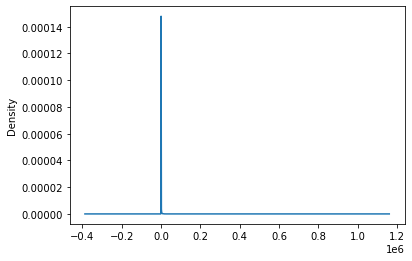

In [15]:
data_train['ClaimAmount'].loc[data_train['ClaimAmount']!=0].plot(kind='kde')

In [16]:
data_train['ClaimAmount'].loc[data_train['ClaimAmount']!=0].describe()

count     17931.000000
mean       1934.314030
std        9818.284642
min           1.000000
25%         692.815000
50%        1172.000000
75%        1204.000000
max      774411.500000
Name: ClaimAmount, dtype: float64

# Factors - **Update from here**

## Exposure

The exposure, in years

Expected range is 0-1, 'vehicle years'
- Remove all exposures over 1, 
- Remove all exposures under 10% (not sufficient exposure)


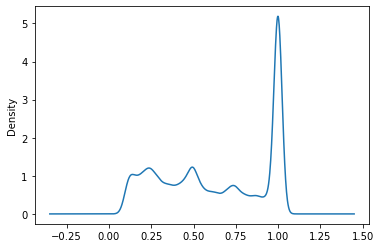

In [22]:
data['Exposure'].plot(kind='kde')

In [23]:
data['Exposure'].describe()

count    417511.000000
mean          0.630649
std           0.319448
min           0.100000
25%           0.330000
50%           0.630000
75%           1.000000
max           1.000000
Name: Exposure, dtype: float64

### Correlation with Claim

In [24]:
data[['ClaimNb_Binary', 'Exposure']].corr(method='spearman')

,Exposure
Exposure,1.0


In [25]:
data[['ClaimNb', 'Exposure']].corr(method='spearman')

,ClaimNb,Exposure
ClaimNb,1.000000,0.051338
Exposure,0.051338,1.000000


In [26]:
data_raw[['ClaimNb', 'Exposure']].corr(method='spearman')

,ClaimNb,Exposure
ClaimNb,1.000000,0.074543
Exposure,0.074543,1.000000


Cutting out the low exposure policies reduces the correlation between claim and exposure.

In [27]:
def view_bins(data, field, target):
    t_data = data.copy()
    field_bins = field + '_bins'
    t_data[field_bins] = pd.cut(t_data[field], bins=20)
    chart = data[[field_bins,target]].groupby(by=field_bins).mean().plot(kind='bar')
    return chart

In [29]:
#view_bins(data, 'Exposure', 'ClaimNb')

## Area

Discrete, No actions, good split of areas


In [30]:
discrete_table(data_raw['Area'])

,count,percentage
value,,
C,144167,28.3%
D,113784,22.3%
E,103260,20.3%
A,78376,15.4%
B,56417,11.1%
F,13631,2.7%


## VehPower

The power of the car (ordered categorical)
- Categorical
- Could group power ratings if required (L,M,H)


Insurance groups	Vehicle make and models
0-5	    Fiat Panda Active, Citroen C1, Skoda Fabia Classic, Toyota Aygo, Ford KA, Vauxhall Corsa
6-10	Chevrolet Matiz, Citroen C3, Ford Fiesta, Fiat 500, Mazda 2
11-15	Audi A2, Ford Focus, Honda Civic, Kia Cee'd, Mitsubishi Colt

In [31]:
discrete_table(data_raw['VehPower'])

,count,percentage
value,,
6,112058,22.0%
7,109298,21.4%
5,93829,18.4%
4,86897,17.1%
8,35277,6.9%
10,23586,4.6%
9,22399,4.4%
11,13790,2.7%
12,6160,1.2%


## BonusMalus

A numeric for the bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.

- Historic claims factor
- Presented as coninuous but not sure if the scale is linear 
- Possibly treat as category (H.M.L)



In [32]:
data_raw['BonusMalus'].describe()

count    509635.000000
mean         59.787993
std          15.667390
min          50.000000
25%          50.000000
50%          50.000000
75%          65.000000
max         230.000000
Name: BonusMalus, dtype: float64

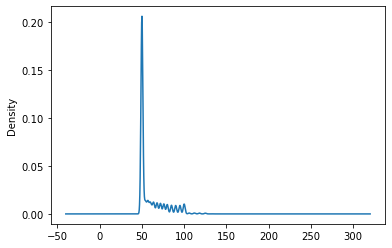

In [33]:
data_raw['BonusMalus'].plot(kind='kde')

## VehBrand
- Categorical

In [34]:
discrete_table(data_raw['VehPower'])

,count,percentage
value,,
6,112058,22.0%
7,109298,21.4%
5,93829,18.4%
4,86897,17.1%
8,35277,6.9%
10,23586,4.6%
9,22399,4.4%
11,13790,2.7%
12,6160,1.2%


## VehGas

In [35]:
discrete_table(data_raw['VehGas'])

,count,percentage
value,,
Regular,260232,51.1%
Diesel,249403,48.9%


## Region

The policy region in France (based on the 1970-2015 classification).
- 22 regions

In [36]:
discrete_table(data_raw['Region']).sort_index()

,count,percentage
value,,
R11,52578,10.3%
R21,2286,0.4%
R22,6032,1.2%
R23,6544,1.3%
R24,120706,23.7%
R25,8214,1.6%
R26,7851,1.5%
R31,20462,4.0%
R41,9694,1.9%


## DrivAgeBand

The driver age, in years (in France, people can drive a car at 18).

- very few under 25, remove as this is a high-risk age bracket and could distort results without sufficient observations

In [37]:
discrete_table(data_raw['DrivAgeBand'])

,count,percentage
value,,
"(35,45]",128229,25.2%
"(45,55]",121602,23.9%
"(25,35]",111796,21.9%
"(55,65]",68446,13.4%
"(65,Inf]",50202,9.9%
"(18,25]",28807,5.7%
"(18, 25]",553,0.1%


In [38]:
data['DrivAgeBand'] = data['DrivAgeBand'].apply(lambda x: x.replace("(",""))
data['DrivAgeBand'] = data['DrivAgeBand'].apply(lambda x: x.replace("]",""))
data = data.loc[data['DrivAgeBand']!='18, 25']

In [39]:
discrete_table(data['DrivAgeBand'])

,count,percentage
value,,
"35,45",103226,24.7%
"45,55",101490,24.3%
"25,35",86793,20.8%
"55,65",58031,13.9%
"65,Inf",44566,10.7%
"18,25",23016,5.5%
"18, 25",0,0.0%


## DensityBand
The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

In [40]:
discrete_table(data_raw['DensityBand'])

,count,percentage
value,,
"(400,1e+03]",214382,42.1%
"(1e+03,2e+03]",169853,33.3%
"(200,400]",57877,11.4%
"(100,200]",36459,7.2%
"(0,50]",17529,3.4%
"(50,100]",13535,2.7%


## VehAgeBand

The vehicle age, in years

In [41]:
discrete_table(data_raw['VehAgeBand'])

,count,percentage
value,,
1,53556,10.5%
2,44593,8.7%
0,43617,8.6%
15+,38765,7.6%
3,37756,7.4%
4,32618,6.4%
5,29034,5.7%
10,28889,5.7%
6,26782,5.3%
